In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import re
import time
import nltk
import pickle
import chardet
from collections import Counter

import lightgbm

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, plot_confusion_matrix

## Load and train existing model

In [4]:
def concate_df(df_list, drop_cols=['Unnamed: 0']):
    """
        Concatenates several data frames along first axis.
        Also generate target vector corresponding to data frame position in the list.
        
        drop_cols - list of column names for removing.
    """
    y = []    # target vector
    for i, df in enumerate(df_list):
        y.extend([i] * df.shape[0])
    
    data = pd.concat(df_list, axis=0, ignore_index=True)
    data.drop(columns=drop_cols, inplace=True)

    return data, y


def build_corpus(df, col_indx=0):
    """
        Creates list of texts.
        
        col_indx - index of column that contains texts.
    """
    corpus = []
    for i in range(df.shape[0]):
        value = df.iloc[i, col_indx]
        if type(value) == str:
            corpus.append(value)
        else:
            corpus.append('')
    return corpus


def clear_line(line):
    """
        Reading file of key words.
    """
    line = line.lower()
    line = line.replace('\n', '')       # replace new line symbol
    line = re.split('[,:] *', line)     # split line by ', *'
    if line[-1] == '':                  # remove empty element in the last position
        line.pop()
    
    return line


def read_patterns_file(path_file, encoding='utf-8'):
    """
        Reads file of key word patterns. Each group of patterns must be devided by empty line.
        Return dictionary of pattern group indices and corresponding list of patterns.
    """
    k = 0
    patterns = {k: []}
    with open(path_file, 'r', encoding=encoding) as file:
        reader = (line for line in file.readlines())
        
        while True:
            try:
                line = next(reader)
                new_line = clear_line(line)
                
                if len(new_line) == 0:
                    k += 1
                    patterns[k] = []
                else:
                    patterns[k].extend(new_line)
                    
            except Exception as error:
                print(error)
                break
                
    return patterns


def create_add_features(corpus, patterns):
    """
        Creates additional feature matrix based on cooccurance of pattern words.
        
        patterns - dictionary of pattern group indices and corresponding list of patterns.
    """
    all_patterns = []
    feature_names = []
    for ptrn in patterns.values():
        feature_names.extend(ptrn)
        all_patterns.extend([' ' + w + ' ' for w in ptrn])
        
    add_matrix = [0] * len(corpus)
    for pattern in all_patterns:
        tmp_feature = [0] * len(corpus)
        for i in range(len(corpus)):
            f = len(re.findall(pattern, corpus[i]))
            if f > 0:
                tmp_feature[i] = f
        add_matrix = np.vstack((add_matrix, tmp_feature))
    
    return add_matrix[1:, :].T, feature_names


def batch_predict(model, df, data_encoder, feature_mask=None, patterns=None, text_col=0, batch_size=10000):
    """
        Performs batch prediction mode.
        
        Params:
            model        - trained model that can make classification.
            df           - data frame which rows need to be classified.
            data_encoder - object for encoding corpus into numbers.
            feature_mask - bool array for feature selection.
            patterns     - dictionary of pattern group indices and corresponding list of word patterns.
                           Use it if you need add new features based on word patterns.
            text_col     - column index that contains text.
            batch_size   - number of rows for one pass.
    """
    pred = []
    for i in range(0, df.shape[0], batch_size):
        tmp_corpus = build_corpus(df.iloc[i:i + batch_size, :], col_indx=text_col)
        x_tmp = data_encoder.transform(tmp_corpus)
        
        if patterns:
            tmp_add_features, _ = create_add_features(corpus=tmp_corpus, patterns=patterns)
            x_tmp = np.hstack((x_tmp.toarray(), tmp_add_features))
            
        if type(feature_mask) == np.ndarray:
            x_tmp = x_tmp[:, feature_mask]
            
        pred.extend(np.argmax(model.predict(x_tmp), axis=1))
        
    return pred

In [5]:
df1 = pd.read_excel('df_invest_neg_morf.xlsx')
df2 = pd.read_excel('df_pens_neg_morf.xlsx')
df3 = pd.read_excel('df_strah_neg_morf.xlsx')
df4 = pd.read_excel('Благо4.xlsx')

df1_new = pd.read_excel('Общий файл отзывов_4_1.xlsx')
df2_new = pd.read_excel('Общий файл отзывов_4_2.xlsx')

In [6]:
# prepare data for train/test
data, y = concate_df(df_list=[df1, df2, df3, df4])
corpus = build_corpus(data)
patterns = read_patterns_file(path_file='Метки.txt')
additional_features, add_feat_names = create_add_features(corpus=corpus, patterns=patterns)

stopwords = nltk.corpus.stopwords.words('russian')
vectorizer = TfidfVectorizer(min_df=20, stop_words=stopwords)
X = vectorizer.fit_transform(corpus)

X_plus = np.hstack((X.toarray(), additional_features))

X_train, X_test, y_train, y_test = train_test_split(X_plus, y, test_size=0.33, random_state=42)
lgb_train = lightgbm.Dataset(X_train, y_train)
lgb_eval = lightgbm.Dataset(X_test, y_test, reference=lgb_train)

In [7]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclassova',
    'num_class': 4, 
    'metric': 'softmax', 
    'num_leaves': 6,
    'learning_rate': 0.1,
    'feature_fraction': 1.,
    'bagging_fraction': 0.8,
    'bagging_freq': 5, 
    'reg_alpha': 3.0, 
    'is_unbalance': True,
    'verbose': 0
}

start = time.time()
gbm = lightgbm.train(params,
                     lgb_train,
                     num_boost_round=110,
                     valid_sets=lgb_eval,
                     early_stopping_rounds=10, 
                     verbose_eval=10)
end = time.time()
print('\nTrain duration: {} s'.format(end - start))

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's multi_logloss: 0.368493
[20]	valid_0's multi_logloss: 0.233353
[30]	valid_0's multi_logloss: 0.188921
[40]	valid_0's multi_logloss: 0.169686
[50]	valid_0's multi_logloss: 0.16087
[60]	valid_0's multi_logloss: 0.156857
[70]	valid_0's multi_logloss: 0.152883
[80]	valid_0's multi_logloss: 0.151864
[90]	valid_0's multi_logloss: 0.151162
Early stopping, best iteration is:
[85]	valid_0's multi_logloss: 0.151048

Train duration: 6.712383985519409 s


In [8]:
print('Accuracy on train: ', accuracy_score(y_train, np.argmax(gbm.predict(X_train), axis=1)))
print('Accuracy on test: ', accuracy_score(y_test, np.argmax(gbm.predict(X_test), axis=1)))

Accuracy on train:  0.9403156384505021
Accuracy on test:  0.9213744903902155


In [9]:
print(classification_report(y_test, np.argmax(gbm.predict(X_test), axis=1)))

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       344
           1       0.78      0.90      0.83       330
           2       0.98      0.92      0.95      1892
           3       0.89      0.98      0.93       868

    accuracy                           0.92      3434
   macro avg       0.88      0.90      0.88      3434
weighted avg       0.93      0.92      0.92      3434



In [10]:
print(confusion_matrix(y_test, np.argmax(gbm.predict(X_test), axis=1)))

[[ 267   10    9   58]
 [   7  297   21    5]
 [  31   72 1748   41]
 [   3    4    9  852]]


In [11]:
np.array(add_feat_names)[(gbm.feature_importance() != 0)[-128:]]

array(['фонд\\w*', 'электроэнерг\\w*', 'инвест\\w*', 'облиг\\w*',
       'депозитар\\w*', 'страх\\w* част\\w*', 'накопит\\w* часть',
       'перев\\w* пенс\\w*'], dtype='<U32')

In [12]:
features_mask = gbm.feature_importance() != 0

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_plus[:, features_mask], 
                                                            y, 
                                                            test_size=0.33, 
                                                            random_state=42)

lgb_train_p = lightgbm.Dataset(X_train_p, y_train_p)
lgb_eval_p = lightgbm.Dataset(X_test_p, y_test_p, reference=lgb_train_p)

start_p = time.time()
gbm_p = lightgbm.train(params,
                       lgb_train_p,
                       num_boost_round=110,
                       valid_sets=lgb_eval_p,
                       early_stopping_rounds=10, 
                       verbose_eval=False)
end_p = time.time()

print('Train duration: {} s'.format(end_p - start_p))

Train duration: 1.4820847511291504 s


In [14]:
print(classification_report(y_test_p, np.argmax(gbm_p.predict(X_test_p), axis=1)))

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       344
           1       0.77      0.90      0.83       330
           2       0.98      0.92      0.95      1892
           3       0.89      0.98      0.94       868

    accuracy                           0.92      3434
   macro avg       0.88      0.90      0.88      3434
weighted avg       0.93      0.92      0.92      3434



In [15]:
pred1 = batch_predict(gbm, df1_new, vectorizer, feature_mask=None, text_col=1, patterns=patterns)
pred2 = batch_predict(gbm, df2_new, vectorizer, feature_mask=None, text_col=1, patterns=patterns)

In [16]:
Counter(pred1), Counter(pred2)

(Counter({3: 38617, 1: 1611, 0: 824, 2: 3946}),
 Counter({3: 44268, 0: 715, 2: 2421, 1: 1935}))

## Saving and loading the model

In [18]:
### save the model
#with open('classifier.pkl', 'wb') as file:
#    pickle.dump(gbm, file, protocol=4)

In [12]:
# save patterns dictionary
#with open('patterns.pkl', 'wb') as file:
#    pickle.dump(patterns, file, protocol=4)

In [13]:
# save vectorizer
#with open('vectorizer.pkl', 'wb') as file:
#    pickle.dump(vectorizer, file, protocol=4)

In [19]:
# load the model
with open('classifier.pkl', 'rb') as file:
    clf = pickle.load(file)
    
# load patterns
with open('patterns.pkl', 'rb') as file:
    ptr = pickle.load(file)
    
# load vectorizer
with open('vectorizer.pkl', 'rb') as file:
    vct = pickle.load(file)

In [20]:
print('Accuracy on train: ', accuracy_score(y_train, np.argmax(clf.predict(X_train), axis=1)))
print('Accuracy on test: ', accuracy_score(y_test, np.argmax(clf.predict(X_test), axis=1)))

Accuracy on train:  0.9403156384505021
Accuracy on test:  0.9213744903902155


In [21]:
pred1 = batch_predict(clf, df1_new, vct, feature_mask=None, text_col=1, patterns=ptr)
pred2 = batch_predict(clf, df2_new, vct, feature_mask=None, text_col=1, patterns=ptr)

In [22]:
print(Counter(pred1))
print(Counter(pred2))

Counter({3: 38617, 2: 3946, 1: 1611, 0: 824})
Counter({3: 44268, 2: 2421, 1: 1935, 0: 715})


# Dirty version

In [158]:
df1 = pd.read_excel('df_invest_neg_morf.xlsx')
df2 = pd.read_excel('df_pens_neg_morf.xlsx')
df3 = pd.read_excel('df_strah_neg_morf.xlsx')
df4 = pd.read_excel('Благо4.xlsx')

# target vector
y = np.array([0] * df1.shape[0] + [1] * df2.shape[0] + [2] * df3.shape[0] + [3] * df4.shape[0])

# deleting useless column
data = pd.concat([df1, df2, df3, df4], axis=0, ignore_index=True)
data.drop(columns='Unnamed: 0', inplace=True)

# creating bag of docs
corpus = []
for i in range(data.shape[0]):
    corpus.append(data.iloc[i, 0])
    
    
def clear_line(line):
    line = line.lower()
    line = line.replace('\n', '')       # replace new line symbol
    line = re.split('[,:] *', line)     # split line by ', *'
    if line[-1] == '':                  # remove empty element in the last position
        line.pop()
    
    return line


with open('Метки.txt', 'r', encoding='utf-8') as file:
    reader = (line for line in file.readlines())
    k = 0
    patterns = {k: []}
    while True:
        try:
            line = next(reader)
            new_line = clear_line(line)
            
            if len(new_line) == 0:
                k += 1
                patterns[k] = []
            else:
                patterns[k].extend(new_line)
                
        except Exception as error:
            print(error)
            break

In [159]:
stopwords = nltk.corpus.stopwords.words('russian')

vectorizer = TfidfVectorizer(min_df=20, stop_words=stopwords)
X = vectorizer.fit_transform(corpus)

all_patterns = []
for part in patterns.values():
    all_patterns.extend([' ' + w + ' ' for w in part])
    
add_matrix = [0] * len(corpus)
for pattern in all_patterns:
    tmp_feature = [0] * len(corpus)
    for i in range(len(corpus)):
        f = len(re.findall(pattern, corpus[i]))
        if f > 0:
            tmp_feature[i] = f
    add_matrix = np.vstack((add_matrix, tmp_feature))
    
    
add_matrix = add_matrix[1:, :]
mtr = add_matrix.T

# add to main feature matrix
X_plus = np.hstack((X.toarray(), mtr))

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X_plus, y, test_size=0.33, random_state=42)

lgb_train = lightgbm.Dataset(X_train, y_train)
lgb_eval = lightgbm.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclassova',
    'num_class': 4, 
    'metric': 'softmax', 
    'num_leaves': 6,
    'learning_rate': 0.1,
    'feature_fraction': 1.,
    'bagging_fraction': 0.8,
    'bagging_freq': 5, 
    'reg_alpha': 3.0,
    'verbose': 0
}

start = time.time()
gbm = lightgbm.train(params,
                     lgb_train,
                     num_boost_round=110,
                     valid_sets=lgb_eval,
                     early_stopping_rounds=10)
end = time.time()

[1]	valid_0's multi_logloss: 0.944567
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's multi_logloss: 0.839938
[3]	valid_0's multi_logloss: 0.758092
[4]	valid_0's multi_logloss: 0.697548
[5]	valid_0's multi_logloss: 0.646442
[6]	valid_0's multi_logloss: 0.60251
[7]	valid_0's multi_logloss: 0.565421
[8]	valid_0's multi_logloss: 0.53285
[9]	valid_0's multi_logloss: 0.505212
[10]	valid_0's multi_logloss: 0.481739
[11]	valid_0's multi_logloss: 0.460911
[12]	valid_0's multi_logloss: 0.44248
[13]	valid_0's multi_logloss: 0.425166
[14]	valid_0's multi_logloss: 0.410968
[15]	valid_0's multi_logloss: 0.398369
[16]	valid_0's multi_logloss: 0.386214
[17]	valid_0's multi_logloss: 0.375499
[18]	valid_0's multi_logloss: 0.36629
[19]	valid_0's multi_logloss: 0.358478
[20]	valid_0's multi_logloss: 0.351239
[21]	valid_0's multi_logloss: 0.343743
[22]	valid_0's multi_logloss: 0.337726
[23]	valid_0's multi_logloss: 0.332489
[24]	valid_0's multi_logloss: 0.327161
[25]	valid_0's 

In [161]:
print('Accuracy on train: ', accuracy_score(y_train, np.argmax(gbm.predict(X_train), axis=1)))
print('Accuracy on test: ', accuracy_score(y_test, np.argmax(gbm.predict(X_test), axis=1)))

Accuracy on train:  0.9400286944045911
Accuracy on test:  0.9213744903902155


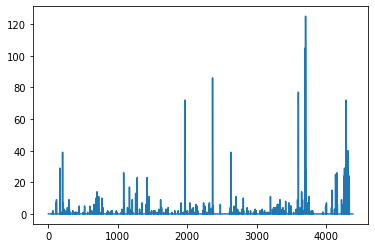

In [162]:
plt.plot(gbm.feature_importance());

In [163]:
features_mask = gbm.feature_importance() != 0

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_plus[:, features_mask], y, 
                                                            test_size=0.33, 
                                                            random_state=42)

lgb_train_p = lightgbm.Dataset(X_train_p, y_train_p)
lgb_eval_p = lightgbm.Dataset(X_test_p, y_test_p, reference=lgb_train_p)

start_p = time.time()
gbm_p = lightgbm.train(params,
                       lgb_train_p,
                       num_boost_round=110,
                       valid_sets=lgb_eval_p,
                       early_stopping_rounds=10)

end_p = time.time()

[1]	valid_0's multi_logloss: 0.944567
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's multi_logloss: 0.839938
[3]	valid_0's multi_logloss: 0.758092
[4]	valid_0's multi_logloss: 0.697548
[5]	valid_0's multi_logloss: 0.646442
[6]	valid_0's multi_logloss: 0.60251
[7]	valid_0's multi_logloss: 0.565421
[8]	valid_0's multi_logloss: 0.53285
[9]	valid_0's multi_logloss: 0.505212
[10]	valid_0's multi_logloss: 0.481739
[11]	valid_0's multi_logloss: 0.460911
[12]	valid_0's multi_logloss: 0.44248
[13]	valid_0's multi_logloss: 0.425166
[14]	valid_0's multi_logloss: 0.410968
[15]	valid_0's multi_logloss: 0.398369
[16]	valid_0's multi_logloss: 0.386214
[17]	valid_0's multi_logloss: 0.375499
[18]	valid_0's multi_logloss: 0.36629
[19]	valid_0's multi_logloss: 0.358478
[20]	valid_0's multi_logloss: 0.351239
[21]	valid_0's multi_logloss: 0.343743
[22]	valid_0's multi_logloss: 0.337726
[23]	valid_0's multi_logloss: 0.332489
[24]	valid_0's multi_logloss: 0.327161
[25]	valid_0's 

In [164]:
print('Accuracy on train: ', accuracy_score(y_train, np.argmax(gbm_p.predict(X_train_p), axis=1)))
print('Accuracy on test: ', accuracy_score(y_test, np.argmax(gbm_p.predict(X_test_p), axis=1)))

Accuracy on train:  0.942467718794835
Accuracy on test:  0.9210832847990681


## Make predictions on new dataset

In [165]:
df1_new = pd.read_excel('Общий файл отзывов_4_1.xlsx')
df2_new = pd.read_excel('Общий файл отзывов_4_2.xlsx')

In [166]:
def prepare_data(df_list):
    # union df's along columns and deleting useless column
    data_new = pd.concat(df_list, axis=0, ignore_index=True)
    data_new.drop(columns='index', inplace=True)
    
    # deleting NA
    data_new.fillna('', inplace=True)
    
    # creating bag of docs
    corpus_new = []
    for i in range(data_new.shape[0]):
        corpus_new.append(data_new.iloc[i, 0])
    
    
    X_new = vectorizer.transform(corpus_new)
        
    add_matrix_new = [0] * len(corpus_new)
    for pattern in all_patterns:
        tmp_feature = [0] * len(corpus_new)
        for i in range(len(corpus_new)):
            f = len(re.findall(pattern, corpus_new[i]))
            if f > 0:
                tmp_feature[i] = f
        add_matrix_new = np.vstack((add_matrix_new, tmp_feature))
        
        
    add_matrix_new = add_matrix_new[1:, :]
    mtr_new = add_matrix_new.T
    return np.hstack((X_new.toarray(), mtr_new))

In [182]:
pred1 = []
step = 10000
for i in range(0, df1_new.shape[0], step):
    x_tmp = prepare_data([df1_new.iloc[i:i + step, :]]) #[:, features_mask]
    pred1.extend(np.argmax(gbm.predict(x_tmp), axis=1))

In [183]:
pred2 = []
step = 10000
for i in range(0, df2_new.shape[0], step):
    x_tmp = prepare_data([df2_new.iloc[i:i + step, :]]) #[:, features_mask]
    pred2.extend(np.argmax(gbm.predict(x_tmp), axis=1))

In [184]:
Counter(pred1)

Counter({3: 38998, 0: 523, 2: 4203, 1: 1274})

In [185]:
Counter(pred2)

Counter({3: 44711, 0: 484, 2: 2592, 1: 1552})

In [63]:
np.savetxt('review_predictions_4_2_1.csv', pred1, delimiter=',', fmt='%.2i')
np.savetxt('review_predictions_4_2_2.csv', pred2, delimiter=',', fmt='%.2i')